### **Imports and parameter fixing**

![books](https://99px.ru/sstorage/53/2015/07/tmb_137166_9563.jpg)


In [37]:
import pandas as pd
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
RANDOM_SEED = 42
VAL_SPLIT=0.2
N_ESTIMATORS=100

!pip freeze > requirements.txt

In [3]:
#loading and joining data for convenience
df_train = pd.read_csv('/kaggle/input/datasets1/main_task.csv')
df_test = pd.read_csv('/kaggle/input/kaggle-beginning-test/kaggle_task.csv')

df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['Rating'] = 0 
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [16]:
#data overview
print('Data main info:\n')
data.info()
print('\n\nData sample:')
display(data.sample(5))
print('Data stats:')
data.describe(include='all').fillna('').T

Data main info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Data sample:


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
9820,id_9820,Bratislava,NaN,359.0,NaN,2.0,"[['Band night'], ['01/24/2014']]",/Restaurant_Review-g274924-d4769869-Reviews-St...,d4769869,0,0.0
46305,id_7747,Paris,['Russian'],7748.0,$$ - $$$,81.0,"[['As a Russian, I can judge', 'Folk Music & G...",/Restaurant_Review-g187147-d1467766-Reviews-Au...,d1467766,1,3.5
21010,id_6662,Paris,['French'],6663.0,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g187147-d13002965-Reviews-L...,d13002965,1,5.0
13174,id_2191,Stockholm,NaN,2194.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189852-d5972492-Reviews-Ka...,d5972492,1,3.0
41740,id_601,Brussels,"['French', 'Cafe', 'European', 'Vegetarian Fri...",602.0,$$ - $$$,394.0,"[['A good LPQ at Place du Grand Sablon', 'Good...",/Restaurant_Review-g188644-d1426129-Reviews-Le...,d1426129,1,3.5


Data stats:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Restaurant_id,50000,13094,id_436,19,,,,,,,
City,50000,31,London,7193,,,,,,,
Cuisine Style,38410,10731,['Italian'],1332,,,,,,,
Ranking,50000,,,,3664.43,3700.09,1,972,2278,5241,16444
Price Range,32639,3,$$ - $$$,23041,,,,,,,
Number of Reviews,46800,,,,124.471,294.114,2,9,33,115,9660
Reviews,49998,41857,"[[], []]",8112,,,,,,,
URL_TA,50000,49963,/Restaurant_Review-g187514-d2360290-Reviews-Lo...,2,,,,,,,
ID_TA,50000,49963,d8753348,2,,,,,,,
sample,50000,,,,0.8,0.400004,0,1,1,1,1


### **Data preprocessing and feature engineering** 

![stuff](https://i.pinimg.com/originals/52/27/7f/52277f8c1e2f9a6331d75e72306871b5.jpg)

We'll first deal with nan values and numerical features, and move on to other features afterwards. 

In [17]:
#create a separate feature for nan cases in 'Number of Reviews' and fill na values
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8') 
data['Number of Reviews'] = data['Number of Reviews'].fillna(0) 

# add mean number of reviews for the restaurant in each city as a feature 
temp_data = data.pivot_table(index = ['City'], values = ['Ranking','Number of Reviews'], aggfunc = {'Ranking':'max','Number of Reviews':'sum'})
temp_data['av_rew_num'] = temp_data['Number of Reviews']/temp_data['Ranking']
av_rev_num = dict()
for row in temp_data.iterrows():
    av_rev_num[row[0]] = round(row[1][2],0)
data['Number of Reviews_av'] = data['City'].map(av_rev_num)

If we look at the ranking of restaurants in different cities, we can notice, that they are not "equal". Thus, in simple words, the No.150 restaurant in a small town with 200 restaurants in total is not the same as No.150 in a big city with 2000 restaurants. 

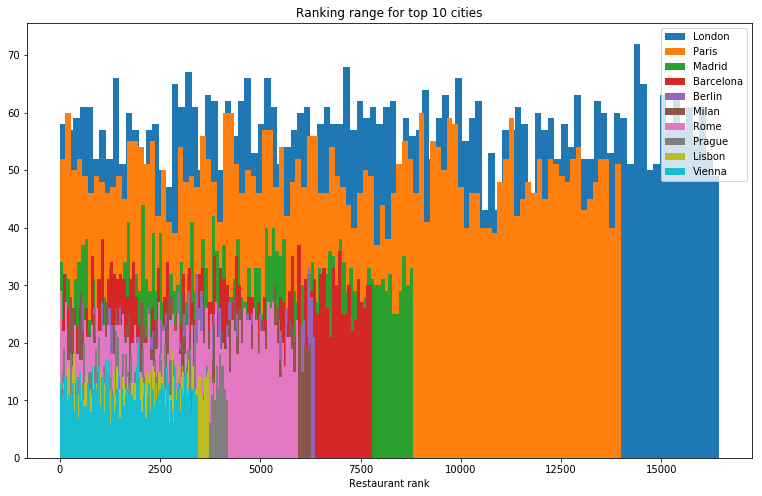

In [28]:
plt.figure(figsize=(13,8))
for city in (df_train['City'].value_counts())[0:10].index:
    plt.hist(df_train['Ranking'][df_train['City'] == city], bins=100, label=city)
    plt.legend()
plt.title('Ranking range for top 10 cities')
plt.xlabel('Restaurant rank');

To make it all correct we scale the ranking in regard to the maximal ranking for each city.

In [29]:
data['Ranking_norm'] = data['Ranking']/data['City'].map(data.groupby('City')['Ranking'].max())

Convert price range from str to integer, fill missing values and add mean price range per city.

In [30]:
data['converted_Price Range'] = data['Price Range'].map({'$':1,'$$ - $$$':2,'$$$$':3}).fillna(2)

data['mean_Price Range'] = data['City'].map(data.groupby('City')['converted_Price Range'].mean())
data.drop('converted_Price Range', axis = 1, inplace = True)

Preprocess 'Cuisine Style' feature and create an extra feature as a mean number of styles per city.

In [31]:
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Vegetarian Friendly']")
data['Cuisine Style'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'") 
data['Cuisine Quantity'] = data['Cuisine Style'].apply(lambda x: len(x))
data['mean_Cuisine Quantity'] = data['City'].map(data.groupby('City')['Cuisine Quantity'].mean())
data.drop('Cuisine Quantity', axis = 1, inplace = True)

Work on reviews (review dates mainly). 

In [32]:
#fill na
data['Reviews'] = data['Reviews'].fillna("['nodata']")
# extract dates
data['Reviews_dates'] = data['Reviews'].str.findall('\d+/\d+/\d+')

def time_passed(row):
    if row['Reviews_dates'] == []:
        return None
    return pd.datetime.now() - pd.to_datetime(row['Reviews_dates']).max()

def time_btw_reviews(row):
    if row['Reviews_dates'] == []:
        return None
    return pd.to_datetime(row['Reviews_dates']).max() - pd.to_datetime(row['Reviews_dates']).min()

# create a feature indicating how many days passed from the last review
data['Reviews_last'] = data.apply(time_passed, axis = 1).dt.days
data['Reviews_isNAN'] = pd.isna(data['Reviews_last']).astype('uint8') 
data['Reviews_last'] = data['Reviews_last'].fillna(data['Reviews_last'].mean())

# create another feature with the number of days between the first and the last review on the restaurant
data['Reviews_delta'] = data.apply(time_btw_reviews, axis = 1).dt.days
data['Reviews_delta'] = data['Reviews_delta'].fillna(0)
data.drop('Reviews_dates', axis = 1, inplace = True)

Use restaurant ID and region code from URL as two more features.

In [33]:
data['ID_TA_num'] = data['ID_TA'].apply(lambda x: x[1:]).astype('int64')

data['Region'] = data['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('int64')

We also add population of the city and two extra, scrapped features, which are visitors rates and number of photos on a restaurant page.

In [34]:
population = {'Paris': 2190327, 'Stockholm': 961609, 'London': 8908081, 'Berlin': 3644826, 'Munich': 1456039, 'Oporto': 237591,'Milan': 1378689,'Bratislava': 432864, 'Vienna': 1821582, 'Rome': 4355725, 'Barcelona': 1620343, 'Madrid': 3223334,'Dublin': 1173179,'Brussels': 179277, 'Zurich': 428737, 'Warsaw': 1758143, 'Budapest': 1752286, 'Copenhagen': 615993,'Amsterdam': 857713,'Lyon': 506615, 'Hamburg': 1841179,'Lisbon': 505526, 'Prague': 1301132, 'Oslo': 673469,'Helsinki': 643272,'Edinburgh': 488100,'Geneva': 200548, 'Ljubljana': 284355,'Athens': 664046, 'Luxembourg': 115227,'Krakow': 769498}
data['Population'] = data['City'].map(population)

data['Marks'] = pd.read_csv('/kaggle/input/extra-data/Marks_full.csv', index_col = 0)

def marks_to_cols(row):
    if row['Marks'] == '[]':
        return [0,0,0,0,0]
    else:
        return list(map(int, re.sub(r"[\[\]\']", '', row['Marks']).split(',')))
    
data['Marks'] = data.apply(marks_to_cols, axis = 1)
data = pd.concat([data, data['Marks'].apply(pd.Series).rename(columns = lambda x : 'Mark_' + str(x))], axis = 1)

data['Photos'] = pd.read_csv('/kaggle/input/extra-data/photos_full_corrected.csv', index_col = 0)

In the end we do one-hot-encoding for some categorical features.

In [35]:
# установим метки на города
data = pd.concat([data, pd.get_dummies(data['City'],dummy_na=True)], axis = 1)

# обозначим наличие в ресторане той или иной кухни
cuisines = set()
for item in data['Cuisine Style']:
    for i in item:
        cuisines.add(i)
def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in cuisines:
    data[item] = data['Cuisine Style'].apply(find_item)
    
# и закодируем уровень цен
data = pd.concat([data, pd.get_dummies(data['Price Range'], dummy_na = True)], axis = 1)

Drop the columns we won't use for training.

In [36]:
data = data.drop(['Restaurant_id', 'City', 'Cuisine Style','Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'Ranking', 'Marks'], axis = 1)

### **To the model**

![indaforest](https://404store.com/2017/04/08/magicforest95.jpg)


We split first our features and target, and then training and validation sets.

In [38]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)

y = train_data['Rating'].values           
X = train_data.drop(['Rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

As a model we use predefined RandomForestRegressor with fixed parameters.

In [39]:
model = RandomForestRegressor(n_estimators=N_ESTIMATORS, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s


MAE: 0.17854499999999998


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


### **Now, is there any way to improve the score?**

#### 1. **For example, we can study feature_importance**

Like this:

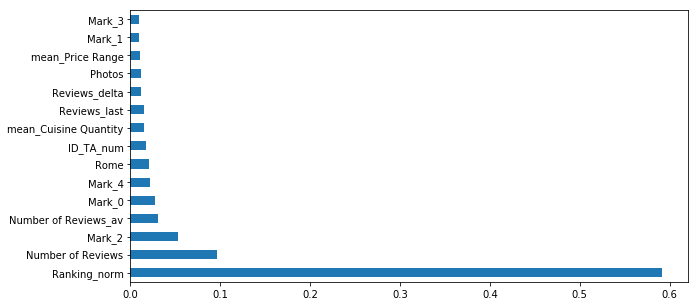

In [43]:
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

and make feature selection manually, or using automated feature_selector (https://proglib.io/p/feature-selector/).

#### 2. **It was also easy to notice that ratings are discrete numbers between 1.0 and 5.0, with step 0.5.**

Why not to round model predictions in this case?

In [44]:
y_pred_round = np.round(model.predict(X_test)*2)/2
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.1401875


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Really worth it!